In [1]:
import os 
from dotenv import load_dotenv
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['HF_TOKEN']=os.getenv('HF_TOKEN')
os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')


### VECTOR DB

In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from pydantic import BaseModel,Field


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
embd=HuggingFaceEmbeddings(model_name="BAAI/bge-large-en-v1.5",)

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs= [WebBaseLoader(url).load() for url in urls]
docs_list=[item for sublist in docs for item in sublist]

text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500,chunk_overlap=0
)
doc_splits= text_splitter.split_documents(docs_list)

vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=embd
)

retriever=vectorstore.as_retriever()

/home/ammar/Documents/Learning/Ai agents/coding/agents/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel,Field

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score:str =Field(
        description="Documents are relevant to the question, 'yes' or 'no' "

    )

llm=ChatGroq(model="llama-3.1-8b-instant")
structure_llm_grader=llm.with_structured_output(GradeDocuments)

In [5]:
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [6]:
retrievel_grader=grade_prompt | structure_llm_grader
question='agent memory'
docs=retriever.invoke(question)
doc_txt=docs[1].page_content
print(retrievel_grader.invoke({"question":question,"document":doc_txt}))


binary_score='yes'


In [7]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt= hub.pull("rlm/rag-prompt")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain=prompt | llm | StrOutputParser()

generation= rag_chain.invoke({"context":docs,"question":question})
print(generation)


In a LLM-powered autonomous agent system, long-term memory provides the agent with the capability to retain and recall information over extended periods, often by leveraging an external vector store and fast retrieval. This allows the agent to retain and recall (infinite) information over extended periods.


In [8]:
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)
question_rewriter=re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question":question})

'Here\'s an improved version of the question, optimized for web search:\n\n"What are the characteristics and limitations of agent memory in artificial intelligence?"\n\nThis revised question includes the following enhancements:\n\n1. **Specific keywords**: "agent memory" is now more explicit, making it easier for search engines to identify the topic.\n2. **Contextual keywords**: "artificial intelligence" provides additional context, helping to narrow down the search results to relevant information.\n3. **Descriptive phrases**: "characteristics and limitations" clarifies the user\'s intent, making it easier for search engines to understand the type of information being sought.\n4. **Clear and concise language**: The revised question is shorter and more straightforward, reducing the likelihood of misinterpretation.\n\nBy rephrasing the question in this way, we can improve the chances of getting accurate and relevant search results.'

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_Search_tool=TavilySearchResults(k=3)


/tmp/ipykernel_13740/2344661843.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_Search_tool=TavilySearchResults(k=3)


In [10]:
from typing import List 
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    
    """
    question: str 
    generation: str
    web_Search: str
    documents: List[str]
    

In [11]:
from langchain.schema import Document

def retrieve(state):
    """
    Retriever documents
    Args:
        state (dict): The current graph state 
    
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents 
    """
    print("---RETRIEVE---")
    question=state["question"]

    documents=retriever.invoke(question)
    return {"documents":documents,"question":question}

In [12]:
def generate(state):
    """
    Generate answer
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    
    """
    print("---GENERATE---")
    question=state["question"]
    documents=state["documents"]

    generation= rag_chain.invoke({"context":documents,"question":question})
    return {"documents": documents,"question":question,"generation":generation}

In [13]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    Args:
        state(dict): The current graph state 
    
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state['question']
    documents = state['documents']

    filtered_docs = []

    web_search= 'No'
    for d in documents:
        score = retrievel_grader.invoke(
            {"question":question,"document":d.page_content}
        )
        grade = score.binary_score
        if grade == 'yes':
            print("---GRADE: DOCUMENT REVELANT---")
            filtered_docs.append(d)
        
        else:
            print("---GRADE DOCUMENT RELEVANT---")
            filtered_docs.append(d)
            web_search = 'Yes'
            continue

        return{"documents":filtered_docs,"question":question,"web_search":web_search}
        



In [14]:
def transform_query(state):
    """
    Transform the query to produce a better question.
    Args:
        state(dict): The current graph state
    Returns:
        state(dict): Updates question key with a re-phrased question
    
    """

    print("---TRANSFORM QUERY---")
    question= state["question"]
    documents= state['documents']

    better_question= question_rewriter.invoke({"question":question})
    return {"documents":documents,"question":better_question}
    

In [15]:
from langchain.schema import Document  # make sure you imported this

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_Search_tool.invoke({"query": question})

    # Handle different return types safely
    if isinstance(docs, str):
        web_results_text = docs
    elif isinstance(docs, list):
        if hasattr(docs[0], "page_content"):  # Document objects
            web_results_text = "\n".join([d.page_content for d in docs])
        elif isinstance(docs[0], str):  # plain strings
            web_results_text = "\n".join(docs)
        elif isinstance(docs[0], dict) and "content" in docs[0]:  # dict style
            web_results_text = "\n".join([d["content"] for d in docs])
        else:
            raise TypeError(f"Unexpected list item type: {type(docs[0])}")
    else:
        raise TypeError(f"Unexpected type for docs: {type(docs)}")

    # Wrap in a Document and add to the existing list
    web_results = Document(page_content=web_results_text, metadata={"source": "web_search"})
    documents.append(web_results)

    return {"documents": documents, "question": question}


In [16]:
def decide_to_generate(state):
    """
    Determine whether to generate an answer, or re-generate a question.

    Args:
        state(dict): The current graph state
    
    Returns:
        str: Binary decision for next node to call
    
    """
    print("---ASSESS GRADED DOCUMENTS---")
    state['question']
    web_search= state["web_search"]
    state['documents']

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCMUENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
        return "transform_query"
    else:
        # we have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [17]:
from langgraph.graph import StateGraph,START,END

workflow=StateGraph(GraphState)

workflow.add_node("retrieve",retrieve)
workflow.add_node("grade_documents",grade_documents)
workflow.add_node("generate",generate)
workflow.add_node("transform_query",transform_query)
workflow.add_node("web_search_node",web_search)

workflow.add_edge(START,"retrieve")
workflow.add_edge("retrieve","grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query":"transform_query",
        "generate":"generate"
    }
)
workflow.add_edge("transform_query","web_search_node")
workflow.add_edge("web_search_node","generate")
workflow.add_edge("generate",END)

app= workflow.compile()





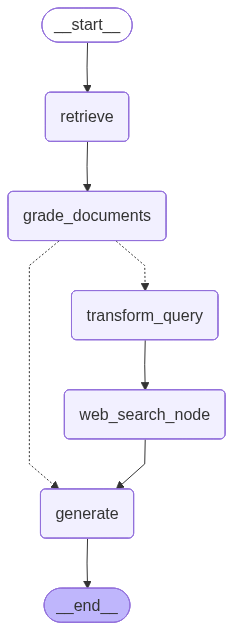

In [18]:
from IPython.display import display,Image

display(Image(app.get_graph().draw_mermaid_png()))

In [19]:
app.invoke({"question":"What are the types of agent memory?"})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT REVELANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---


{'question': 'What are the types of agent memory?',
 'generation': 'The types of agent memory mentioned are short-term memory and long-term memory. Short-term memory is utilized for in-context learning, while long-term memory enables the agent to retain and recall information over extended periods.',
 'documents': [Document(id='f86e06c0-2e84-40d0-ac2b-1ef7d5edfd25', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key compon

In [21]:
app.invoke({"question":"what is machine learning"})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE DOCUMENT RELEVANT---
---GRADE: DOCUMENT REVELANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCMUENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
---WEB SEARCH---
---GENERATE---


{'question': 'Here\'s an improved version of the question:\n\n"What are the fundamental concepts and definitions of machine learning, including its history and applications?"\n\nThis revised question is optimized for web search because it:\n\n1. Specifies a clear topic: Machine learning\n2. Indicates a need for in-depth information: "fundamental concepts and definitions"\n3. Suggests a desire for historical context: "history"\n4. Shows interest in practical applications: "applications"\n\nThis formulation is likely to yield more relevant and comprehensive search results, as it provides a clearer direction for the search engine to match.',
 'generation': 'Machine learning is a subfield of artificial intelligence that involves training algorithms to learn from data and make predictions or decisions without being explicitly programmed. Its fundamental concepts include supervised and unsupervised learning, neural networks, and deep learning.',
 'documents': [Document(id='e3839652-a8f0-46cc